# Finite differences

Compute finite difference coefficients on an arbitrary grid symbolically, and evaluate the exact coefficients in the case of a uniform grid with unit spacing.

Demonstrate usage and convergence of finite differences on a toy example.

In [1]:
import numpy as np, math, sympy as sp
import itertools
from IPython.display import display, HTML, Math
import matplotlib.pyplot as plt
import matplotlib_tufte
matplotlib_tufte.setup()

In [2]:
def compute_fd_coefs(grid: np.ndarray | list[sp.Symbol | sp.Number], der: int, acc: int, method: str, symbolic: bool = False) -> np.ndarray | sp.Matrix:
    """Computes finite difference coefficients for the derivative of f(x) with order `der` and error term of order `acc`.

    The returned coefficients are stored in an array of shape (nwindows, n), where
      - n = der + acc + (-1 if der % 2 == 0 and method == 'centered' else 0)
        is the number of points required for one evaluation of finite differences
      - nwindows = max(1, len(grid)-n+1)
        is the number of contiguous slices of `grid` with `n` elements

    `grid` is the set of points where f(x_i) is sampled, and may be non-uniform (see below).
    If `symbolic == True`, `grid` should be a list of Sympy symbols or numbers

    `method` can take the following values
      - 'forward': the derivative is evaluated at the first element of the window
      - 'backward': the derivative is evaluated at the last element of the window
      - 'centered': the derivative is evaluated at the middle element of the window

    `symbolic` controls the use of sympy for the evaluation of the coefficients.
    Setting `symbolic=True` can be useful to compare with results in the literature on uniform grids, see
    Fornberg, Bengt (1988), "Generation of Finite Difference Formulas on Arbitrarily Spaced Grids" Mathematics of Computation, 51 (184): 699–706.
    For numerical evaluation (e.g. on non-uniform grids), `symbolic=False` uses numpy to solve the linear system and is faster
    """
    
    if method not in ['forward', 'backward', 'centered']:
        raise RuntimeError(f'method {method} not recognized. valid methods are forward,backward,centered')
    
    if method == 'centered' and acc % 2 == 1:
        raise RuntimeError('centered finite differences have even orders in accuracy')
        
    n = der + acc + (-1 if der % 2 == 0 and method == 'centered' else 0)  # number of points per evaluation of finite differences
    assert len(grid) >= n, f'not enough grid points given for the derivative={der} and acc={acc}, at least {n} required'
    nwindows = max(1, len(grid)-n+1)
    
    fdcoefs = sp.zeros(nwindows, n) if symbolic else np.zeros((nwindows, n))

    for iw in range(nwindows):
        c = 0 if method == 'forward' else \
            -1 if method == 'backward' else \
            n // 2 if method == 'centered' else None
        
        # set the zero point of the grid (we evaluate the derivative at x = 0)
        x = grid[iw:iw+n]
        x_ = x[:] - x[c]

        S = sp.zeros(n,n) if symbolic else np.zeros((n,n))
        for i in range(n): S[i, :] = [[ s**i for s in x_ ]] if symbolic else x_**i
        
        D = sp.zeros(n,1) if symbolic else np.zeros(n)
        D[der] = [sp.Integer(math.factorial(der))] if symbolic else math.factorial(der)

        fdcoefs[iw, :] = [next(iter(sp.linsolve((S, D))))] if symbolic else np.linalg.solve(S, D)

    return fdcoefs

In [3]:
def demo_fd_coefs(der_maxs: tuple[int, int], acc_maxs: tuple[int, int], symbolic_grid: bool):
    html = """
    <style>
    /*td {
        max-width: 30px !important;
        overflow-x: scroll !important;
    }*/
    </style>
    """

    def ncoefs(der, acc, method):
        return der + acc + (-1 if der % 2 == 0 and method == 'centered' else 0)
    
    for method in 'centered', 'forward', 'backward':
        acc_min = 2 if method == 'centered' else 1
        acc_max = acc_maxs[0] if method == 'centered' else acc_maxs[1]
        der_max = der_maxs[0] if method == 'centered' else der_maxs[1]
        acc_step = 2 if method == 'centered' else 1
        accs = list(range(acc_min, acc_max+1, acc_step))
        ncoefs_max = ncoefs(der_max, acc_max, method)
        idx_offset_max = ncoefs_max//2 if method == 'centered' else \
                      0 if method == 'forward' else \
                      ncoefs_max-1 if method == 'backward' else \
                      None

        # table header
        html += f'<b>{method} finite differences</b>'
        html += '<table><tbody>'
        html += f"""<tr>
            <th rowspan="2">order of the derivative</th>
            <th rowspan="2">order of the error</th>
            <th colspan="{ncoefs_max}">index of the coefficient</th>
        </tr>"""

        # index of coefficients
        html += '<tr>'
        for i in np.arange(ncoefs_max) - idx_offset_max:
            html += f'<td>{i}</td>'
        html += '</tr>'
        
        for der in range(1, der_max+1):
            first_acc = True
                
            for acc in accs:
                # grid = np.arange(ncoefs(der, acc, method))
                nc = ncoefs(der, acc, method)
                r = range(-nc//2+1, nc//2+1) if method == 'centered' else \
                    range(0, nc) if method == 'forward' else \
                    range(-nc+1, 1) if method == 'backward' else None
                grid = np.array([sp.Symbol(f'x_{{{i}}}', real=True) for i in r]) if symbolic_grid else \
                       np.array([sp.Rational(i) for i in r])
                coefs = compute_fd_coefs(grid, der=der, acc=acc, method=method, symbolic=True)
                nskip =  (ncoefs_max - len(coefs))//2 if method == 'centered' else \
                         0 if method == 'forward' else \
                         (ncoefs_max - len(coefs)) if method == 'backward' else None

                html += '<tr>'
                html += f'<td rowspan={len(accs)}>{der}</td>' if first_acc else ''
                html += f'<td>{acc}</td>'
                html += '<td></td>'*nskip
                if symbolic_grid:
                    html += ''.join(f'<td>${sp.latex(c.simplify().factor())}$</td>' for c in coefs[0,:])
                else:
                    html += ''.join(f'<td>${sp.latex(c)}$<br>≈ {float(c.evalf(4)):.3f}</td>' for c in coefs[0,:])
                html += '<td></td>'*(ncoefs_max - len(coefs) -nskip)
                html += '</tr>'

                first_acc = False
            
        html += '</tbody></table>'

    return html

Compute finite difference coefficients on an arbitrary grid.

Orders of the derivative and error are computed for a few combinations, and get ugly very fast.

In [4]:
display(HTML(demo_fd_coefs((3,3), (2,2), symbolic_grid=True)))

Compute finite difference coefficients exactly on a uniform grid with unit spacing.

In [5]:
display(HTML(demo_fd_coefs((6,6), (8,6), symbolic_grid=False)))

Numerical demonstration on the toy function $f(x) = \\sin(x)$.

We take samples on a nonuniform grid, and compare finite difference methods at difference orders of errors, and compute the $\ell_2$ norm to quantify the error.

Forward differences misses the last point(s), backward differences misses the first point(s), centered differences misses first and last point(s).

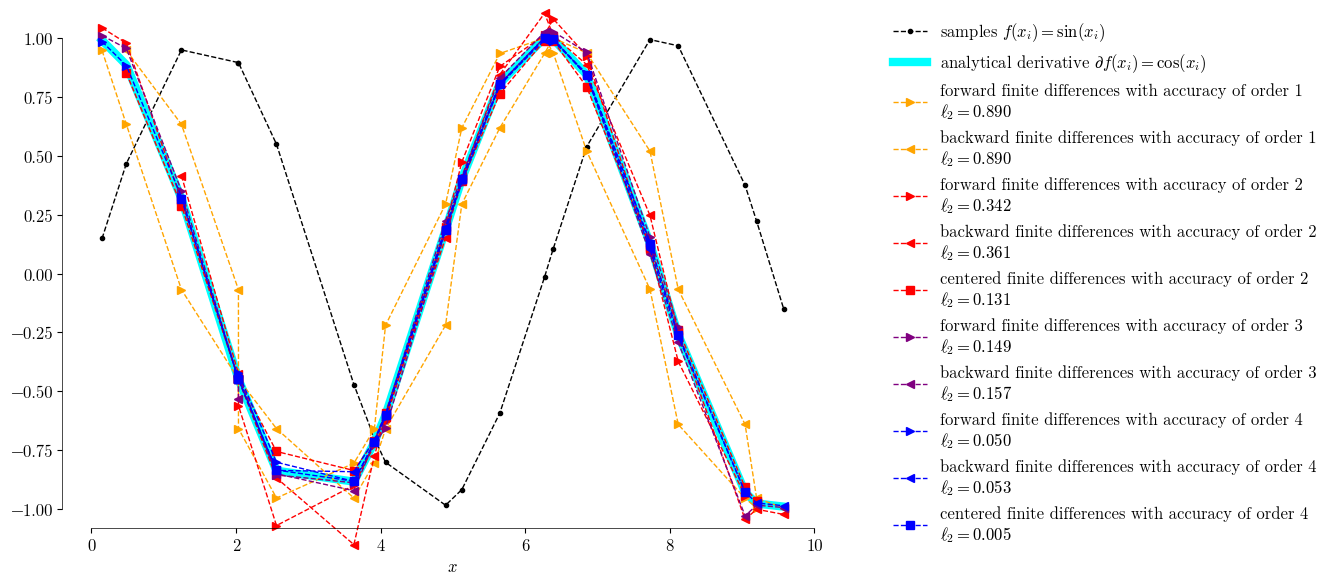

In [6]:
t = np.linspace(0, 10, 20)
# add some random noise to the sample locations to get a nonuniform grid
np.random.seed(42)
t += np.random.normal(scale=0.3, size=len(t))
t = np.sort(t)

f = np.sin(t)
df = np.cos(t)

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(t, f, linestyle='--', marker='.', label='samples $f(x_i) = \\sin(x_i)$', clip_on=False)
ax.plot(t, df, linestyle='-', color='cyan', label='analytical derivative $\\partial f(x_i) = \\cos(x_i)$', linewidth=6, clip_on=False)

for acc, method in itertools.product([1,2,3,4], ['forward', 'backward', 'centered']):
    if method == 'centered' and acc % 2 == 1: continue
    df_num = np.full_like(f, np.nan)
    w = compute_fd_coefs(grid=t, der=1, acc=acc, method=method)
    ncoefs = w.shape[1]
    # where the derivative is evaluated in the window of size ncoefs
    di = ncoefs//2 if method == 'centered' else \
         0 if method == 'forward' else \
         ncoefs-1 if method == 'backward' else None
    for iw in range(len(w)):
        df_num[iw+di] = (f[iw:iw+ncoefs] * w[iw]).sum()
    l2 = np.sqrt(np.nansum((df - df_num)**2))
    ax.plot(t, df_num,
            linestyle='--',
            marker={'forward': '>', 'backward': '<', 'centered': 's'}[method],
            color={1: 'orange', 2: 'red', 3: 'purple', 4: 'blue'}[acc],
            label=f'{method} finite differences with accuracy of order {acc}\n$\\ell_2 = {l2:.3f}$', clip_on=False)

ax.set(xlabel='$x$', ylim=[-1,1], xlim=[0,10])
ax.legend(bbox_to_anchor=[1.1,1.05], borderaxespad=0)
matplotlib_tufte.breathe(ax)
plt.show()